## Rag com Agentes Especializados
O conhecimento organizacional pode ser dividido em diversas áreas.
Agentes especializados ficam responsáveis por áreas específicas do conhecimento.
Isso DEVE ser feito na parte do retrieval, com os PDFs sendo divididos em subseções assim como os VectorDBs.
Um agente de rotas é necessário.

[Router Agent] ──► Decide qual agente responde <br>
    ├── [Agent Produtos] ──► Retriever Produtos + LLM + Prompt <br>
    ├── [Agent Processos] ──► Retriever Processos + LLM + Prompt <br>
    └── [Agent Políticas] ──► ...

Instalar as dependencias

In [5]:
%pip install langchain langchain_mistralai langchain-groq langchain-community langchain-core langgraph mistralai chromadb ipywidgets pypdf

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importando as bibliotecas necessárias

In [7]:
import os
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_mistralai import MistralAIEmbeddings
from langchain_groq import ChatGroq
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from typing import TypedDict, List
from langchain.schema import Document
from langgraph.graph import START, StateGraph
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv
load_dotenv()

True

Criação dos Vectorstores

In [10]:
# Função para text splitt e chunking dos documentos
def load_and_process_documents(diretorio: str):
    loader = PyPDFDirectoryLoader(diretorio)
    documents = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=150
    )
    chunks = text_splitter.split_documents(documents)
    return chunks

# ----- Produtos -----
def store_embeddings_produtos():
    chunks = load_and_process_documents("data/produtos")
    embeddings = MistralAIEmbeddings()

    vectordb = Chroma.from_documents(
        chunks,
        embedding=embeddings,
        persist_directory="vectorstores/produtos",
        collection_name="produtos"
    )

    vectordb.persist()
    print(f"Vectorstore criado em {"vectorstores/produtos"}")
    return vectordb

# ---- Processos ----
def store_embeddings_processos():
    chunks = load_and_process_documents("data/processos")
    embeddings = MistralAIEmbeddings()

    vectordb = Chroma.from_documents(
        chunks,
        embedding=embeddings,
        persist_directory="vectorstores/processos",
        collection_name="processos"
    )

    vectordb.persist()
    print(f"Vectorstore criado em {"vectorstores/processos"}")
    return vectordb

# ---- RH ----
def store_embeddings_rh():
    chunks = load_and_process_documents("data/recursos_humanos")
    embeddings = MistralAIEmbeddings() 

    vectordb = Chroma.from_documents(
        chunks,
        embedding=embeddings,
        persist_directory="vectorstores/recursos_humanos",
        collection_name="recursos_humanos"
    )

    vectordb.persist()
    print(f"Vectorstore criado em {"vectorstores/recursos_humanos"}")
    return vectordb

store_embeddings_processos()
store_embeddings_produtos()
store_embeddings_rh()


Overwriting cache for 0 284


Vectorstore criado em vectorstores/processos
Vectorstore criado em vectorstores/produtos
Vectorstore criado em vectorstores/recursos_humanos


Criando os Retrievers Especializados

In [11]:
# Retriever de produtos
def get_retriever_produtos():
    embeddings = MistralAIEmbeddings()
    vectordb = Chroma(
        persist_directory="vectorstores/produtos",
        collection_name="produtos",
        embedding_function=embeddings
    )
    retriever = vectordb.as_retriever(search_kwargs={"k": 3})
    return retriever

# Retriever de processos
def get_retriever_processos():
    embeddings = MistralAIEmbeddings()
    vectordb = Chroma(
        persist_directory="vectorstores/processos",
        collection_name="processos",
        embedding_function=embeddings
    )
    retriever = vectordb.as_retriever(search_kwargs={"k": 3})
    return retriever

# Retriever de RH
def get_retriever_rh():
    embeddings = MistralAIEmbeddings()
    vectordb = Chroma(
        persist_directory="vectorstores/rh",
        collection_name="rh",
        embedding_function=embeddings
    )
    retriever = vectordb.as_retriever(search_kwargs={"k": 3})
    return retriever

Criando os Agentes Especializados

In [12]:
# 1. Definição do estado
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Prompt Agente de Produtos
prompt_agente_produtos = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Você é um especialista na documentação de produtos da empresa. 
Utilize exclusivamente as informações fornecidas no contexto abaixo para responder à pergunta.

Contexto:
{context}

Pergunta:
{question}

Se a resposta não estiver no contexto, diga "Informação não encontrada no contexto.".
Resposta:
"""
)

# Prompt Agente de Processos
prompt_agente_produtos = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Você é um especialista na documentação de processos da empresa. 
Utilize exclusivamente as informações fornecidas no contexto abaixo para responder à pergunta.

Contexto:
{context}

Pergunta:
{question}

Se a resposta não estiver no contexto, diga "Informação não encontrada no contexto.".
Resposta:
"""
)

# Prompt Agente de RH
prompt_agente_produtos = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Você é um especialista na documentação de Recursos Humanos da empresa. 
Utilize exclusivamente as informações fornecidas no contexto abaixo para responder à pergunta.

Contexto:
{context}

Pergunta:
{question}

Se a resposta não estiver no contexto, diga "Informação não encontrada no contexto.".
Resposta:
"""
)

Testando os Agentes Individualmente

c:\projects\Rag-Multi-Agente-GC\.venv\Lib\site-packages\langchain_mistralai\embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


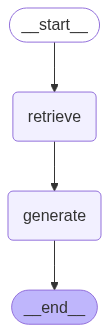

In [18]:
llm = ChatGroq(model="llama3-70b-8192")  # Ou qualquer outro LLM configurado
retriever = get_retriever_produtos() 

# Nó de recuperação
def retrieve(state: State):
    docs = retriever.get_relevant_documents(state["question"])
    return {"context": docs}

# Nó de geração de resposta
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    prompt_value = prompt_agente_produtos.format(question=state["question"], context=docs_content)
    response = llm.invoke([HumanMessage(content=prompt_value)])
    return {"answer": response.content}


# 6. Construção do grafo
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")

graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Testando pergunta simples

In [19]:
pergunta = input("Digite sua pergunta sobre Produtos: ")

estado_inicial = {
    "question": pergunta,
    "context": [],
    "answer": ""
}

resultado = graph.invoke(estado_inicial)
print("\nResposta:")
print(resultado["answer"])


Resposta:
A metodologia de desenvolvimento de sistemas adotada pela Coordenadoria de Informática é o SCRUM.
